In [1]:
from functions import *

## Expectations

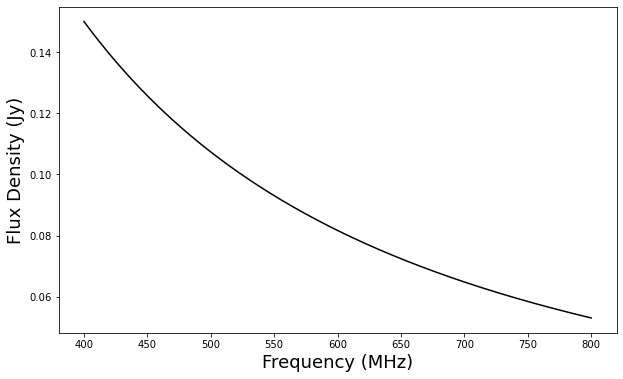

In [2]:
# Spectrum of the pulsar
freqs = np.linspace(800, 400, 1024)
pulsar_spectrum = flux_density(
    freqs, 
    ref_flux = 0.15,
    ref_freq = 400, 
    spectral_index = -1.5
)

fig = plt.figure(figsize=(10,6))
plt.plot(freqs, pulsar_spectrum, color='black')
plt.xlabel('Frequency (MHz)', fontsize=18)
plt.ylabel('Flux Density (Jy)', fontsize=18)
plt.show()

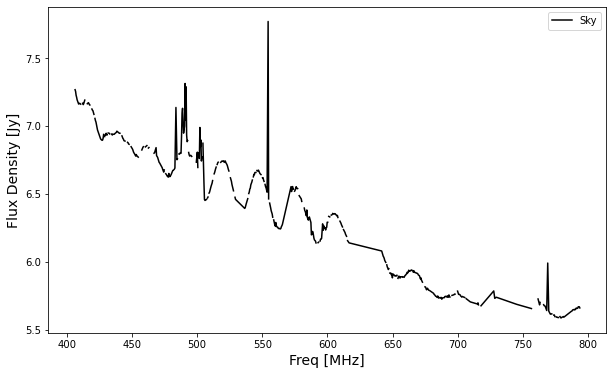

In [3]:
# Load average sky spectrum (SEFD)
sky_data = np.load("./data/calibrated_sky.npz")
sky_array = sky_data["array"]
sky_spectrum = sky_data["spectrum"]
sky_freq_mask = sky_data["freq_mask"]
df = sky_data["freq_bandwidth"]
dt = sky_data["sampling_time"]

fig = plt.figure(figsize=(10, 6))
plt.plot(
    freqs[sky_freq_mask], 
    sky_spectrum[sky_freq_mask],
    color='black',
    label='Sky'
)
plt.ylabel('Flux Density [Jy]', fontsize=14)
plt.xlabel('Freq [MHz]', fontsize=14)
plt.legend()
plt.show()

In [4]:
# Calibrator spectrum 
freqs = np.linspace(800, 400, 1024)
cal_spectrum = flux_density(freqs)

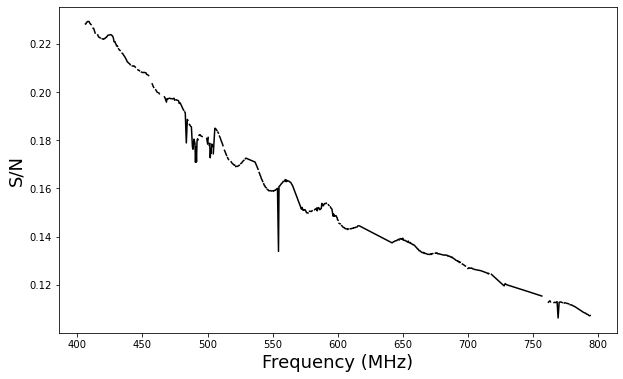

In [5]:
# Given that S/N is proportional to Sv/Ssys * sqrt(N)
N = 1
sn = pulsar_spectrum[sky_freq_mask]/ sky_spectrum[sky_freq_mask] * np.sqrt(dt* df* N)

fig = plt.figure(figsize=(10,6))
plt.plot(freqs[sky_freq_mask], sn, color='black')
plt.xlabel('Frequency (MHz)', fontsize=18)
plt.ylabel('S/N', fontsize=18)
plt.show()

In [6]:
sn_400_1 = sn[-1]
sn_desired = 2
N = np.power(sn_desired/ sn_400_1, 2)
print(f"Number of foldings required to achieve S/N 2: {N}")

Number of foldings required to achieve S/N 2: 77.98680664060242


Output()

Output()

Output()

Output()

Output()

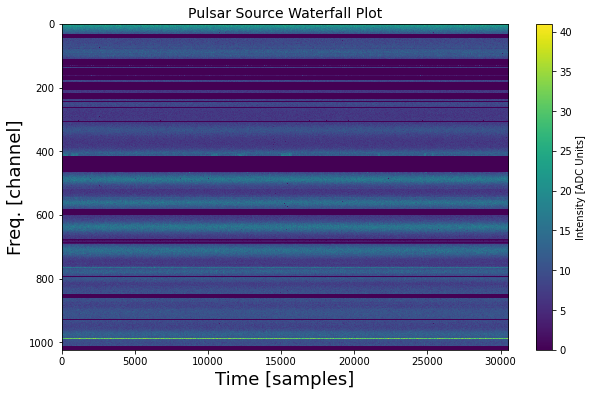

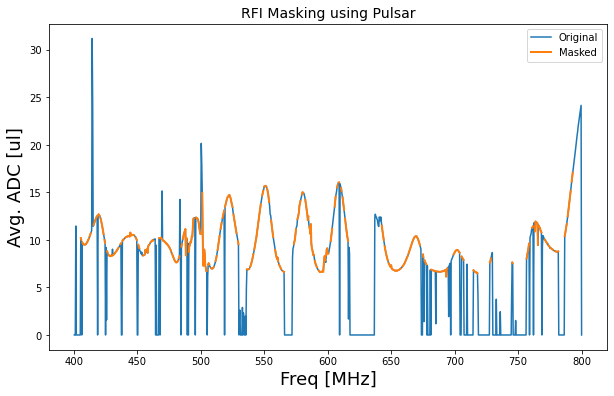

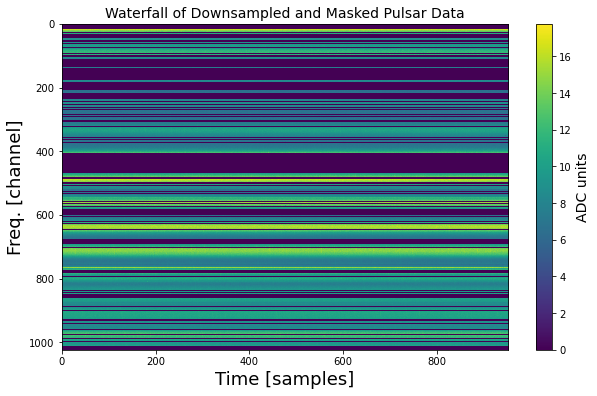

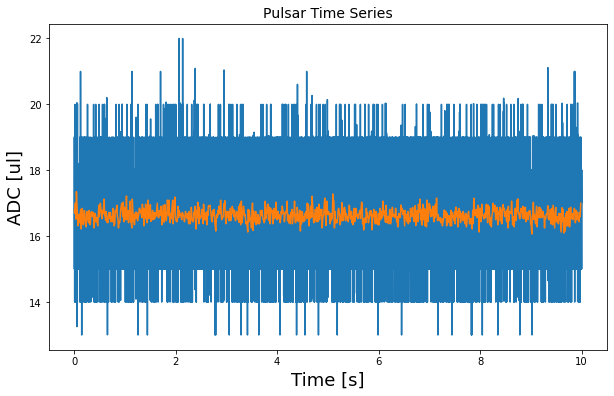

In [11]:
# Read in the data
pulsar = FilReader("./data/pulsardata.fil") 
Pretty(pulsar.header)

pulsar.compute_stats()
pulsar_data = pulsar.read_block(0, pulsar.header.nsamples, pulsar.header.fch1, pulsar.header.nchans)
pulsar_array = pulsar_data.data

# Mask the RFI
_, chan_mask = pulsar.clean_rfi(
    method = "mad",
    threshold=3, 
    outfile_name = "./data/pulsardata_masked.fil",
)
pulsar_masked = FilReader("./data/pulsardata_masked.fil") 
pulsar_masked.compute_stats()

freq_mask = pulsar_masked.chan_stats.mean == 0

# Downsample the data
pulsar_masked.downsample(
    tfactor = 32, 
    outfile_name = "./data/pulsardata_masked_f1_t32.fil"
)
pulsar_32 = FilReader("./data/pulsardata_masked_f1_t32.fil") 
pulsar_32.compute_stats()
pulsar_data_32 = pulsar_32.read_block(0, pulsar_32.header.nsamples, pulsar_32.header.fch1, pulsar_32.header.nchans)
pulsar_32_array = pulsar_data_32.data

# Plot the waterfall
fig = plt.figure(figsize=(10, 6))
plt.imshow(pulsar_array, aspect='auto', interpolation='nearest')
plt.colorbar(label='Intensity [ADC Units]')
plt.title('Pulsar Source Waterfall Plot', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.show()

# Plot the mean spectrum
fig = plt.figure(figsize=(10, 6))
plt.plot(
    pulsar_masked.header.chan_freqs, 
    pulsar.chan_stats.mean, 
)
plt.plot(
    pulsar_masked.header.chan_freqs, 
    np.where(~freq_mask, pulsar_masked.chan_stats.mean, np.nan), 
    linewidth=2, 
)
plt.ylabel('Avg. ADC [ul]', fontsize=18)
plt.xlabel('Freq [MHz]', fontsize=18)
plt.title('RFI Masking using Pulsar', fontsize=14)
plt.legend(['Original', 'Masked'])
plt.show()

# Waterfall of downsampled data
fig = plt.figure(figsize=(10, 6))
plt.imshow(pulsar_32_array,aspect='auto',interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('ADC units', fontsize=14)
plt.title('Waterfall of Downsampled and Masked Pulsar Data', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.show()

# Timeseries
fig = plt.figure(figsize=(10, 6))
plt.plot(
    np.arange(pulsar.header.nsamples) * pulsar.header.tsamp,
    pulsar_array[~freq_mask,:][1,:]
)
plt.plot(
    np.arange(pulsar_32.header.nsamples) * pulsar_32.header.tsamp,
    pulsar_32_array[~freq_mask,:][1,:]
)
plt.ylabel('ADC [ul]', fontsize=18)
plt.xlabel('Time [s]', fontsize=18)
plt.title('Pulsar Time Series', fontsize=14)
plt.show()

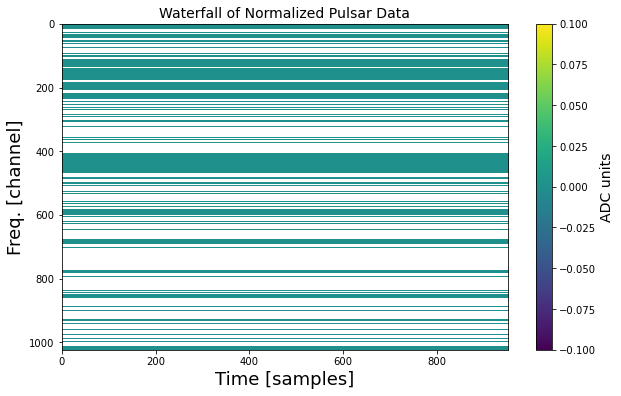

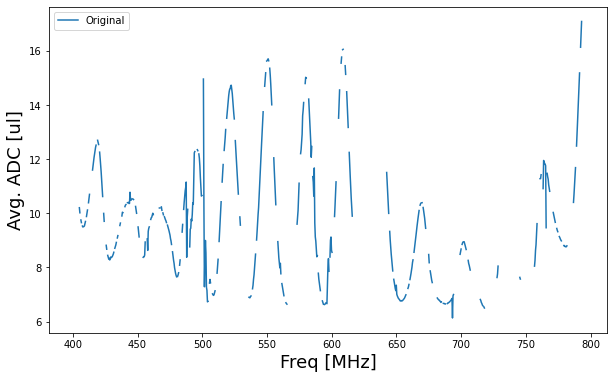

In [28]:
# Normalization
psr_normalized = normalize_data_per_channel(
    pulsar_32_array, 
    freq_mask,    
    invert_mask=True
)

fig = plt.figure(figsize=(10, 6))
plt.imshow(psr_normalized, aspect='auto', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('ADC units', fontsize=14)
plt.title('Waterfall of Normalized Pulsar Data', fontsize=14)
plt.xlabel('Time [samples]', fontsize=18)
plt.ylabel('Freq. [channel]', fontsize=18)
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(
    freqs, 
    np.where(~freq_mask, np.mean(pulsar_32_array, axis=1), np.nan)
)
plt.ylabel('Avg. ADC [ul]', fontsize=18)
plt.xlabel('Freq [MHz]', fontsize=18)
# plt.title('RFI Masking using Pulsar', fontsize=14)
plt.legend(['Original', 'Masked'])
plt.show()